# Import

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
from scipy import stats
import warnings
import statsmodels.api as sm
from numpy.random import rand
import pickle
import os 
from collections import defaultdict 

from src import smc, utils as ut,  model as mdl


warnings.simplefilter('ignore')
plt.style.use('ggplot')
%matplotlib inline
sb.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

# Load

In [3]:
data_dict = ut.build_data_dict(ut.load_rv(filepath='data/rv.pkl'))
tickers = list(data_dict.keys())
model_dict = defaultdict(lambda: {})

In [4]:
fpath = 'checkpoint/'
dir_list = os.listdir(fpath)
dir_list = [x for x in dir_list if x not in ['.DS_Store', 'newpast', 'past']]
md_dict = defaultdict(lambda: {})
for fname in dir_list:
    with open(fpath+fname, 'rb') as f:
        ticker = fname.split('_')[0][1:]
        mdk = fname.split('_')[1].split('.')[0]
        md_dict[ticker][mdk] = pickle.load(f)

# Experiment

## Data statistics

In [5]:
ticker_ls = data_dict.keys()
data_table = []
datastat_table = []

for ticker in data_dict.keys():
    y_train, y_test, rv_train, rv_test, y_all, rv_all, _, date, _, _, _, _,_ = data_dict[ticker]['test'].values()
    n_train = int(date.shape[0]/2)
    st_train = date[0]
    en_train = date[n_train]
    st_test  = date[n_train+1]
    en_test  = date[-1]
    data_table.append([st_train.strftime("%Y-%m-%d")+" - "+en_train.strftime("%Y-%m-%d"),st_test.strftime("%Y-%m-%d")+" - "+en_test.strftime("%Y-%m-%d"),n_train,y_test.shape[0]])
    datastat_table.append([y_all.mean(),y_all.min(),y_all.max(),y_all.std(),stats.skew(y_all),stats.kurtosis(y_all),y_train.mean(),y_train.min(),y_train.max(),y_train.std(),stats.skew(y_train),stats.kurtosis(y_train),y_test.mean(),y_test.min(),y_test.max(),y_test.std(),stats.skew(y_test),stats.kurtosis(y_test)])
    datastat_table.append([rv_all.mean(),rv_all.min(),rv_all.max(),rv_all.std(),stats.skew(rv_all),stats.kurtosis(rv_all),rv_train.mean(),rv_train.min(),rv_train.max(),rv_train.std(),stats.skew(rv_train),stats.kurtosis(rv_train),rv_test.mean(),rv_test.min(),rv_test.max(),rv_test.std(),stats.skew(rv_test),stats.kurtosis(rv_test)])
    
des_df  = pd.DataFrame(data_table, index=ticker_ls, columns=['In-Sample', 'Out-of-Sample', 'T_in', 'T_out'])
idx     = pd.MultiIndex.from_product([ticker_ls,['y','rvs']], names=['index','series'])
data_stat_df = pd.DataFrame(datastat_table, index=idx)
idx_col = pd.MultiIndex.from_product([['all','train','test'],['Mean','min','max','std','skew','kurt']],names=['period','stat'])
data_stat_df.columns = idx_col

In [6]:
# para table to latex
df = des_df.copy()
label = 'data'
caption = 'Dataset specification (all indices)'
hrules = True
multirow_align = 'c'
multicol_align = 'c'

# start 
s = df.style.hide(names=True)
s.format_index(escape=escape, axis=0).format_index(escape=escape, axis=1)


# style to latex
latex = s.to_latex(hrules=hrules, label=label+'full', caption=caption, 
                environment=environment, position=position,
                column_format=column_format)
latex = del_lines(latex, st=6, en=6+9)
latex = chaneg_spacing(latex)

# write
with open(root+label+'_full', 'w') as fp:
    fp.write(latex)

NameError: name 'escape' is not defined

In [46]:
with pd.ExcelWriter('data/result/result.xlsx', mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    des_df.to_excel(writer, sheet_name='data_period', float_format='%.2f')

## Result statistics

In [7]:
# different length becuase somehow self.T = y_train.shape[0] not y_test.shape[0]
reload()
stat_ls, para_train, para_test, mse_ls, rmse_ls, mad_ls = [], [], [], [], [], []
for ticker in ticker_ls:
    for mdk in mdk_ls:
        stat_ls.append(ut.get_stat(md_dict[ticker][mdk], data_dict[ticker]))
        para_train.append(pd.DataFrame.from_records(ut.get_theta_mean(md_dict[ticker][mdk].pre)))
        para_test.append(pd.DataFrame.from_records(ut.get_theta_mean(md_dict[ticker][mdk])))
        # mse
        mse_ls.append(ut.get_stat_mse(md_dict[ticker][mdk].var_ls.reshape((-1,1)), data_dict[ticker]['test']['rm_test'], vol=True, type='mse'))
        rmse_ls.append(ut.get_stat_mse(md_dict[ticker][mdk].var_ls.reshape((-1,1)), data_dict[ticker]['test']['rm_test'], vol=True, type='rmse'))
        mad_ls.append(ut.get_stat_mse(md_dict[ticker][mdk].var_ls.reshape((-1,1)), data_dict[ticker]['test']['rm_test'], vol=True, type='mad'))
    stat_ls.append(ut.get_stat(None, data_dict[ticker], rv=True))

# idx
idx = pd.MultiIndex.from_product([ticker_ls, mdk_ls], names=['index','model'])
idx_para = pd.MultiIndex.from_product([ticker_ls, mdk_ls, ['mean','std']], names=['index','model','metric'])
idx_mean = pd.MultiIndex.from_product([ticker_ls+['Mean'], mdk_ls], names=['index','model'])
idx_mean_para = pd.MultiIndex.from_product([ticker_ls+['Mean'], mdk_ls, ['mean','std']], names=['index','model','metric'])
idx_mean_count = pd.MultiIndex.from_product([ticker_ls+['Mean', 'Count'], mdk_ls], names=['index','model'])
idx_rv = pd.MultiIndex.from_product([ticker_ls, mdk_ls+['rv']], names=['index','model'])
idx_mean_rv = pd.MultiIndex.from_product([ticker_ls+['Mean'], mdk_ls+['rv']], names=['index','model'])

# stat df
stat_df = pd.DataFrame.from_dict(stat_ls)
stat_df.index = idx_rv
stat_df.columns = pd.MultiIndex.from_tuples(stat_df.columns)

# neg marginal llik
stat_df[('train', 'stat', 'Mar.llik')] = -stat_df[('train', 'stat', 'Mar.llik')]

# add bayes factor column
stat_df[('train','stat', 'BF')] = stat_df.loc[(slice(None), mdk_ls), ('train', 'stat', 'Mar.llik')].copy()
mllik = stat_df.loc[(slice(None), mdk_ls), ('train', 'stat', 'Mar.llik')]
for ticker in ticker_ls:
    for mdk in mdk_ls:
        stat_df[('train','stat', 'BF')].loc[(ticker,mdk)] = mllik[ticker][mdk] - mllik[ticker]['garch']  

# stat df + mean 
mean_df = stat_df.mean(axis=0,level='model')
stat_df = pd.concat([stat_df, mean_df])
stat_df.index = idx_mean_rv

# mse 
mse_df = pd.DataFrame.from_dict(mse_ls)
mse_df.index = idx
mean_df = mse_df.mean(axis=0,level='model')
mse_df = pd.concat([mse_df, mean_df])
mse_df.index = idx_mean

# rmse
rmse_df = pd.DataFrame.from_dict(rmse_ls)
rmse_df.index = idx
mean_df = rmse_df.mean(axis=0,level='model')
rmse_df = pd.concat([rmse_df, mean_df])
rmse_df.index = idx_mean

# mad
mad_df = pd.DataFrame.from_dict(mad_ls)
mad_df.index = idx
mean_df = mad_df.mean(axis=0,level='model')
mad_df = pd.concat([mad_df, mean_df])
mad_df.index = idx_mean

# parameters train
para_train_df = pd.concat(para_train)
para_train_df.index = idx_para
mean_df = para_train_df.mean(axis=0, level=['model','metric'])
para_train_df = pd.concat([para_train_df, mean_df])
para_train_df.index = idx_mean_para
mean = para_train_df.loc[(slice(None), slice(None), 'mean')].applymap('{:.3f}'.format)
std = para_train_df.loc[(slice(None), slice(None), 'std')].applymap('{:.3f}'.format)
para_train_df = mean+'+'+std
# para_train_df.replace({'nan\\\\(nan)':'-'}, inplace=True)

# # parameters test
# para_test_df = pd.concat(para_test)
# para_test_df.index = idx
# mean_df = para_test_df.mean(axis=0,level='model')
# para_test_df = pd.concat([para_test_df,mean_df])
# para_test_df.index = idx_mean
# para_test_df.fillna('-', inplace=True)       

# para + Mar.llik + Bayes facotr
pps_df = stat_df['train']['stat'][['Mar.llik']].loc[(slice(None), mdk_ls), :]
pps_df = pps_df.reindex(idx_mean)
# pps_df = pps_df.loc[ticker_selected_ls +['Mean']]
bf_df = stat_df['train']['stat'][['BF']].loc[(slice(None), mdk_ls), :]
bf_df = bf_df.reindex(idx_mean)
# string Bayes factor
para_df = para_train_df[['alpha', 'beta', 'beta0', 'beta1', 'gamma']]
para_df = pd.concat([para_df, pps_df, bf_df], axis=1)
para_df['Mar.llik'] = para_df['Mar.llik']

# count for mse
df = mse_df
count_df = pd.DataFrame(np.zeros(df.shape[0]), index=df.index, columns=['count'])
for ticker in ticker_ls:
    for mdk in mdk_ls:
        for rm in df.columns:
            if df.loc[(ticker, mdk), rm] <= df.loc[ticker, rm].min():
                count_df.loc[(ticker, mdk)] += 1
count_df.loc['Mean'] = count_df.iloc[:-4].mean(axis=0,level='model').to_numpy()
mse_df['count'] = count_df

# count for mad
df = mad_df
count_df = pd.DataFrame(np.zeros(df.shape[0]), index=df.index, columns=['count'])
for ticker in ticker_ls:
    for mdk in mdk_ls:
        for rm in df.columns:
            if df.loc[(ticker, mdk), rm] <= df.loc[ticker, rm].min():
                count_df.loc[(ticker, mdk)] += 1
count_df.loc['Mean'] = count_df.iloc[:-4].mean(axis=0,level='model').to_numpy()
mad_df['count'] = count_df

NameError: name 'reload' is not defined

In [8]:
# trim for only four index and calculate count for 
def get_count(stat_df, metric, ticker_ls, mdk_ls, minimum=True):
    df = stat_df[metric]
    count_df = pd.DataFrame(np.zeros(4), index=mdk_ls, columns=[metric])
    for ticker in ticker_ls:
        for mdk in mdk_ls:
            if minimum and df[ticker][mdk] ==  df[ticker][mdk_ls].min():
                count_df.loc[mdk]+=1
            elif not minimum and df[ticker][mdk] ==  df[ticker][mdk_ls].max():
                count_df.loc[mdk]+=1
    return count_df

stat_trimed_df = stat_df['test']['stat'].loc[(slice(None), mdk_ls), [ 'Qloss_1%', 'JointLoss_1%', 'Qloss_5%', 'JointLoss_5%', 'PPS']].copy()
stat_trimed_df = stat_trimed_df.reindex(idx_mean)
count_df_ls = []
for metric in stat_trimed_df.columns:
    count_df_ls.append(get_count(stat_trimed_df, metric, ticker_ls, mdk_ls))
count_df = pd.concat(count_df_ls, axis=1)
stat_trimed_df = pd.concat([stat_trimed_df, count_df])
stat_trimed_df.index = idx_mean_count

NameError: name 'stat_df' is not defined

### Latex

In [9]:
# df to latex specification
props_bold = 'bfseries: ;'
environment = 'longtable'
clines = 'skip-last;data'
position = '!htbp'
root = 'data/result/latex/'
escape = 'latex'
mnames = ['GARCH', 'RECH', 'RealGARCH', 'RealRECH']
position_float = 'centering'


def del_lines(latex, st=6, en=6+9):
    lines = latex.split('\n')
    lines = [x+'\n' for x in lines]
    del lines[st:en]
    return "".join(lines)

def chaneg_spacing(latex, space=1):
    return '\\begin{{spacing}}{{}}\n'.format(space)+latex+'\end{spacing}'

ticker_selected_ls = ['DJI', 'SPX', 'GDAXI', 'AEX']
ticker_hide_ls = [x for x in ticker_ls if x not in ticker_selected_ls]

### Para latex

In [10]:
mllik_dict = defaultdict(lambda: {})
for ticker in ticker_ls:
    for mdk in mdk_ls:
        mllik_ls = []
        for fname in ['{}_{}_{}.pkl'.format(ticker, mdk, n) for n in range(0,6)]:
            with open(fpath+fname, 'rb') as f:
                md = pickle.load(f)
                mllik_ls.append(ut.get_mllik(md.pre))
        if mdk in ['rech', 'realrech']:
            mllik_dict[ticker][mdk] = np.array(mllik_ls).std()/2
        if mdk =='garch':
            mllik_dict[ticker][mdk] = np.array(mllik_ls).std()*2
        if mdk =='realgarch':
            mllik_dict[ticker][mdk] = np.array(mllik_ls).std()*2
std_df = pd.DataFrame.from_records(mllik_dict).T.stack()
std_df = pd.concat([std_df, std_df.mean(level=1)])
std_df.index = idx_mean
std_df = std_df.apply(lambda x: '{:.3f}'.format(x))

NameError: name 'mdk_ls' is not defined

In [11]:
# para table to latex
df = para_df.copy()
df['Mar.llik']  = df['Mar.llik'] + '+' + std_df 
df.columns = ['$\\alpha$', '$\\beta$', '$\\beta_0$', '$\\beta_1$', '$\gamma$'] + list(df.columns[-2:])
label = 'para'
caption = 'In-sample Analysis: parameters estimation and marginal likelihood'
caption_full = caption + ' (all indices)'
hrules = True
multirow_align = 'c'
multicol_align = 'c'

# cell format specification
idx_ls = df.index.get_level_values(0).unique()
col_ls = df.columns
column_format = 'c'*(df.index.nlevels+df.shape[-1])
format_dict = {col:'{:.3f}' for col in col_ls}
format_dict['count'] = '{:.1f}'

# format and bold bf
def format_bf(x, max):
    if x==0:
        return 1
    elif x==max:
        return '$\mathbf{{e^{{{:.0f}}}}}$'.format(x)
    else:
        return '$e^{{{:.0f}}}$'.format(x)   
for idx in idx_ls:
    max = df.loc[idx, 'BF'].max()
    df.loc[idx, 'BF'] = df.loc[idx, 'BF'].apply(format_bf, max=max).values

# start 
s = df.style
s.hide(names=True)

# special format fn
def format_para(x):
    mean, std = x.split('+')
    if mean == 'nan':
        return '-'
    else:
        return '\\begin{tabular}[c]{@{}c@{}}'+mean+'\\\\ {\\scriptsize('+std+')}\end{tabular}'
# format cell
s.format(format_para, subset=col_ls[:-2])
def format_mllik(x):
    mllik, std = x.split('+')
    return '\\begin{tabular}[c]{@{}c@{}}$'+mllik+'$\\\\ {\\scriptsize('+std+')}\end{tabular}'

s.format(format_mllik, subset='Mar.llik')


# style to latex
latex = s.to_latex(hrules=hrules, label=label+'full', clines=clines, caption=caption+' (all indices)', 
                environment=environment, position=position,
                column_format=column_format)
latex = del_lines(latex, st=6, en=6+9)
latex = chaneg_spacing(latex)

latex_trimed = s.hide(ticker_hide_ls).to_latex(hrules=hrules, label=label, clines=clines, caption=caption, 
                position=position, position_float = 'centering',
                column_format=column_format)
# latex_trimed = del_lines(latex_trimed, st=6, en=6+9)
latex_trimed = chaneg_spacing(latex_trimed)

# write
with open(root+label+'_full', 'w') as fp:
    fp.write(latex)
with open(root+label, 'w') as fp:
    fp.write(latex_trimed)

NameError: name 'para_df' is not defined

### MSE

In [12]:
df = mse_df.copy()
label = 'mse'
caption = 'Forecast performance: MSE to different realized measures'
caption_full = caption + ' (all indices)'

# cell format specification
idx_ls = df.index.get_level_values(0).unique()
col_ls = df.columns
column_format = 'c'*(df.index.nlevels+df.shape[-1])
format_dict = {col:'{:.3f}' for col in col_ls}
format_dict['count'] = '{:.1f}'

# value
s = df.style.hide(names=True)
s.format(format_dict, escape=escape)

# cell
for col in col_ls:
    for idx in idx_ls:
        if col != 'count':
            s.highlight_min(subset=(idx,col), props=props_bold)
        else:
            s.highlight_max(subset=(idx,col), props=props_bold)

# index
s.format_index(escape=escape, axis=0)
s.format_index(escape=escape, axis=1)

# style to latex
latex = s.to_latex(hrules=hrules, label=label+'full', clines=clines, caption=caption_full, 
                environment=environment, position=position,
                column_format=column_format)
latex = del_lines(latex)
latex = chaneg_spacing(latex)

latex_trimed = s.hide(ticker_hide_ls).to_latex(hrules=hrules, label=label, clines=clines, caption=caption, 
                position=position, position_float = 'centering',
                column_format=column_format)
# latex_trimed = del_lines(latex_trimed, st=6, en=6+9)
latex_trimed = chaneg_spacing(latex_trimed)

# write
with open(root+label+'_full', 'w') as fp:
    fp.write(latex)
with open(root+label, 'w') as fp:
    fp.write(latex_trimed)

NameError: name 'mse_df' is not defined

### MAD

In [754]:
df = mad_df.copy()
label = 'mad'
caption = 'Forecast performance: MAD to different realized measures'
caption_full = caption + ' (all indices)'

# cell format specification
idx_ls = df.index.get_level_values(0).unique()
col_ls = df.columns
column_format = 'c'*(df.index.nlevels+df.shape[-1])
format_dict = {col:'{:.3f}' for col in col_ls}
format_dict['count'] = '{:.1f}'

# value
s = df.style.hide(names=True)
s.format(format_dict, escape=escape)

# cell
for col in col_ls:
    for idx in idx_ls:
        if col != 'count':
            s.highlight_min(subset=(idx,col), props=props_bold)
        else:
            s.highlight_max(subset=(idx,col), props=props_bold)

# index
s.format_index(escape=escape, axis=0)
s.format_index(escape=escape, axis=1)

# style to latex
latex = s.to_latex(hrules=hrules, label=label+'full', clines=clines, caption=caption_full, 
                environment=environment, position=position,
                column_format=column_format)
latex = del_lines(latex)
latex = chaneg_spacing(latex)

latex_trimed = s.hide(ticker_hide_ls).to_latex(hrules=hrules, label=label, clines=clines, caption=caption, 
                position=position, position_float = 'centering',
                column_format=column_format)
# latex_trimed = del_lines(latex_trimed, st=6, en=6+9)
latex_trimed = chaneg_spacing(latex_trimed)

# write
with open(root+label+'_full', 'w') as fp:
    fp.write(latex)
with open(root+label, 'w') as fp:
    fp.write(latex_trimed)

### Risk

In [755]:
# stat table to latex
df = stat_trimed_df.copy()
label = 'risk'
caption = 'Forecast performance: tail risk forecast and PPS'
caption_full = caption + ' (all indices)'

# cell format specification
idx_ls = df.index.get_level_values(0).unique()
col_ls = df.columns
column_format = 'c'*(df.index.nlevels+df.shape[-1])

# value
s = df.style
s.format(subset=pd.IndexSlice[idx_ls[:-1], :], precision=3, escape=escape)
s.format(subset=pd.IndexSlice[idx_ls[-1], :], precision=0, escape=escape)

# cell
for col in col_ls:
    for idx in idx_ls:
        if idx != 'Count':
            s.highlight_min(subset=(idx,col), props=props_bold)
        else:
            s.highlight_max(subset=(idx,col), props=props_bold)

# index
s.hide(names=True)
s.format_index(escape=escape, axis=0)
s.format_index(escape=escape, axis=1)


# style to latex
latex = s.to_latex(hrules=hrules, label=label+'full', clines=clines, caption=caption_full, 
                environment=environment, position=position,
                column_format=column_format)
latex = del_lines(latex)
latex = chaneg_spacing(latex)

latex_trimed = s.hide(ticker_hide_ls).to_latex(hrules=hrules, label=label, clines=clines, caption=caption, 
                position=position, position_float = 'centering',
                column_format=column_format)
# latex_trimed = del_lines(latex_trimed, st=6, en=6+9)
latex_trimed = chaneg_spacing(latex_trimed)

# write
with open(root+label+'_full', 'w') as fp:
    fp.write(latex)
with open(root+label, 'w') as fp:
    fp.write(latex_trimed)

## Plot variance forecast

In [17]:
def var_plot(ticker, md_dict, data_dict, gp):
    
    n_train = data_dict[ticker]['test']['rv_train'].shape[0]
    n_test = len(md_dict[ticker]['garch'].var_ls)
    rv_test = np.sqrt(data_dict[ticker]['test']['rv_test'])[:n_test]
    date = data_dict[ticker]['test']['date'][n_train:][:n_test]
    
    mdk_ls = ['garch','rech', 'realgarch','realrech']
    linewidth = 1.5
    st_ls = [0]
    
    for g in gp:
        st_ls.append(st_ls[-1]+g)
    st = np.array(st_ls[:-1])
    en = st+gp
    nn = st.shape[0]
    
    for n,st,en in zip(np.arange(nn),st,en):
        fig, ax = plt.subplots(figsize=(15,5))
        # ax.set_ylim(top=np.array([md_dict[ticker][mdk].var_ls[st:en] for mdk in mdk_ls]).max())
        ax.plot(date[st:en], rv_test[st:en],'--', c='limegreen', label='RVs', linewidth=linewidth*0.75)
        # ax.plot(date[st:en], np.sqrt(md_dict[ticker]['garch'].var_ls[st:en]), '--', c='darkgoldenrod' , label='garch',linewidth=linewidth)
        # ax.plot(date[st:en], np.sqrt(md_dict[ticker]['rech'].var_ls[st:en]), '--', c='dodgerblue', label='rech',linewidth=linewidth)
        ax.plot(date[st:en], np.sqrt(md_dict[ticker]['realgarch'].var_ls[st:en]), '--', c='blue', label='realgarch',linewidth=linewidth)
        ax.plot(date[st:en], np.sqrt(md_dict[ticker]['realrech'].var_ls[st:en]), c='red' , label='realrech',linewidth=linewidth)
        ax.legend()
        # plt.savefig('images/var_{}_{}'.format(ticker,n), bbox_inches='tight')

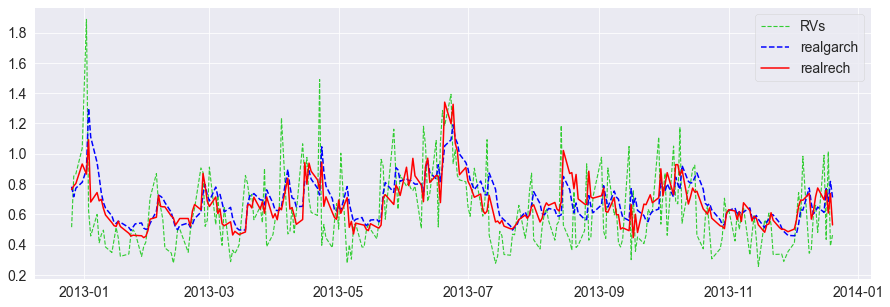

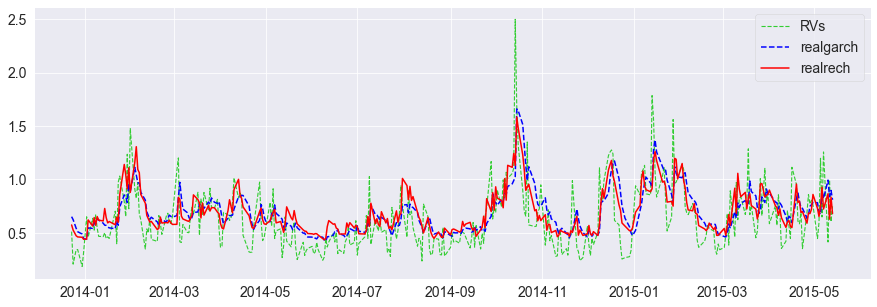

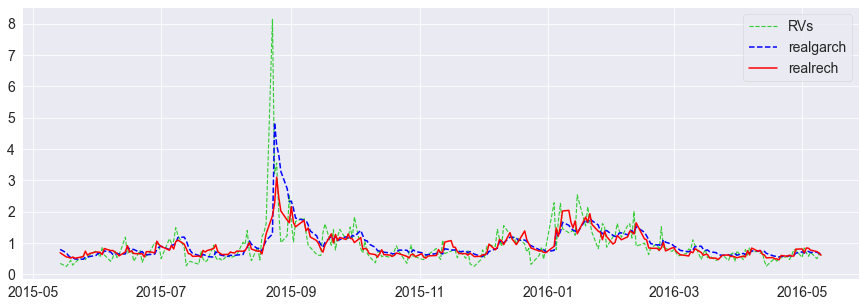

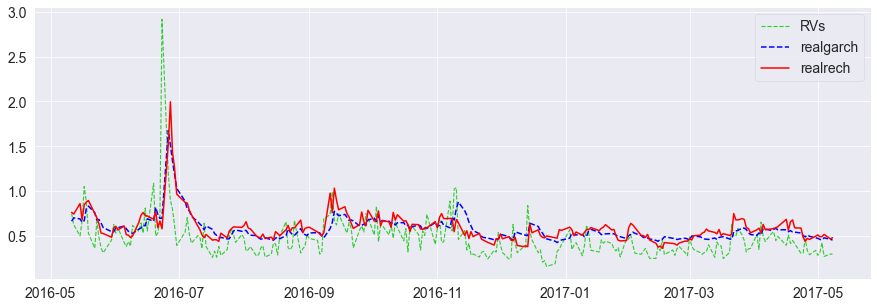

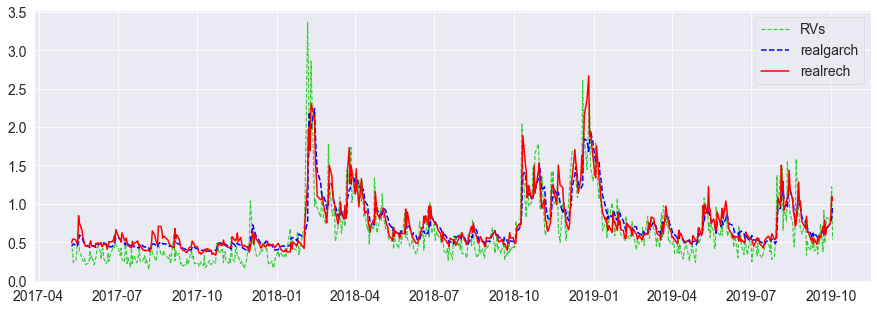

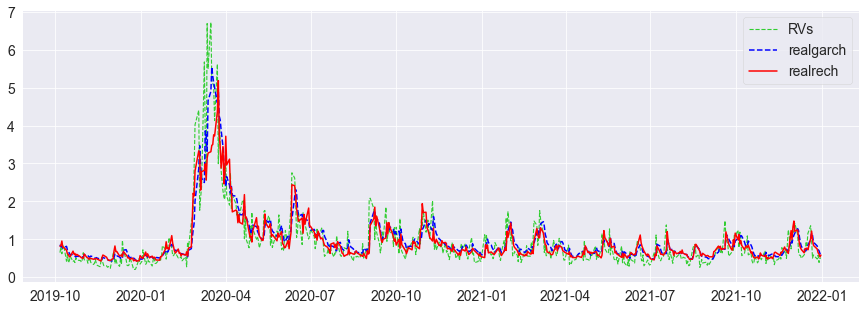

In [18]:
gp = np.array((250,350,250,250,600,600))
var_plot('.DJI', md_dict, data_dict, gp)

## Model performance in different period

[(0.3, 1.0), Text(0.5, 0, 'RVs range'), Text(0.5, 1.0, 'Average')]

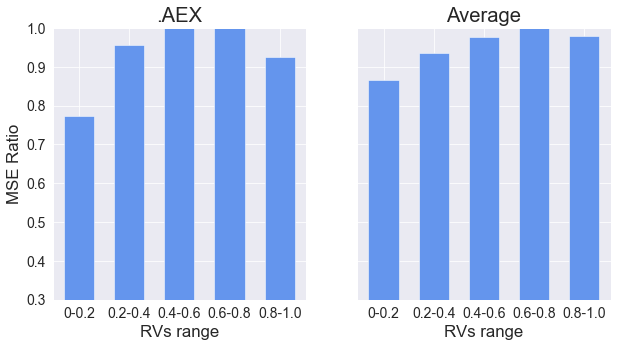

In [11]:
# High volatility period
import math 
rmse_ls = []
md1 = 'realgarch'
md2 = 'realrech'
for ticker in ticker_ls:
    y_test, rv_test = data_dict[ticker]['test']['y_test'], data_dict[ticker]['test']['rv_test']
    
    mse_md1 = np.square(np.sqrt(md_dict[ticker][md1].var_ls)-np.sqrt(rv_test))
    mse_md2 = np.square(np.sqrt(md_dict[ticker][md2].var_ls)-np.sqrt(rv_test))
    mse_md1 = mse_md1[rv_test.argsort()]
    mse_md2 = mse_md2[rv_test.argsort()]
    rmse = []
    n_test = rv_test.shape[0]
    n_step = math.floor(n_test/5)
    arange = np.linspace(0, n_test, 6, dtype=int)

    for st, en in zip(arange[:-1], arange[1:]):
        rmse.append(np.average(mse_md2[st:en])/np.average(mse_md1[st:en]))
    rmse_ls.append(np.array(rmse))
    
rmse_arr = np.array(rmse_ls)
rmse_mean = np.average(rmse_arr, axis=0)

fig, axs = plt.subplots(1,2,figsize=(10,5), sharey=True)
axs[0].bar(['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1.0',], rmse_ls[0], width=0.6, color='cornflowerblue')
axs[0].set(ylim=(0.3,1),xlabel='RVs range', ylabel='MSE Ratio', title=ticker_ls[0])
axs[1].bar(['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1.0',], rmse_mean, width=0.6, color='cornflowerblue')
axs[1].set(ylim=(0.3,1),xlabel='RVs range', title='Average')

## Option trading

In [561]:
data_dict_opttrading = defaultdict(def_value)
for ticker in ticker_ls:
    data_dict_opttrading[ticker] = ut.get_dataset_opttrading(data_df.loc['.'+ticker])

    
def opt_trading(mdk_ls, n_share=1):

    profit_dict = defaultdict(lambda: 0)
    profit_dict_daily = defaultdict(lambda: 0)
    profit_dict_ann = defaultdict(lambda: 0)
    profit_dict_sharpe = defaultdict(lambda: 0)
    profit_ls_dict = defaultdict(lambda: 0)
    k = len(mdk_ls)-1
    rf = (1+0.02)**(1/252)-1
    
    
    for ticker in ticker_ls:

        y_test = data_dict_opttrading[ticker]

        n_test = len(md_dict[ticker]['garch'].var_ls)
        for m1, m2 in itertools.combinations(mdk_ls, 2):
            #var_ls
            m1_var = (md_dict[ticker][m1].var_ls/(10**4))[:n_test]
            m2_var = (md_dict[ticker][m2].var_ls/(10**4))[:n_test]
            # p_t
            m1_p = 2*stats.norm.cdf(0.5*np.sqrt(m1_var)) - 1 
            m2_p = 2*stats.norm.cdf(0.5*np.sqrt(m2_var)) - 1 
            
            # print("{},{},{}".format(ticker,m1_p.shape[0],m2_p.shape[0]))
            p_mid = (m1_p+m2_p) * 0.5 
            N = m1_var.shape[0]
            m1_profit, m2_profit = np.zeros(N), np.zeros(N)

            try:
                for n in range(N):
                    if m1_p[n]>m2_p[n]:
                        m1_profit[n] = np.abs(y_test[n]) - 2*p_mid[n] + y_test[n]*(-m1_p[n])
                        m2_profit[n] = 2*p_mid[n] - np.abs(y_test[n]) - y_test[n]*(-m2_p[n])
                    else:
                        m1_profit[n] = 2*p_mid[n] - np.abs(y_test[n]) - y_test[n]*(-m1_p[n])
                        m2_profit[n] = np.abs(y_test[n]) - 2*p_mid[n] + y_test[n]*(-m2_p[n])
            except Exception as e:
                print(e)
                import pdb; pdb.set_trace()
                
            m1_profit = m1_profit*n_share    
            m2_profit = m2_profit*n_share

            # save
            profit_dict[ticker, m1] += m1_profit.mean()
            profit_dict[ticker, m2] += m2_profit.mean()
            
            profit_ls_dict[ticker, m1] += m1_profit
            profit_ls_dict[ticker, m2] += m2_profit
            profit_dialy_ls_dict = profit_ls_dict.copy()
    
    for key in profit_ls_dict.keys():
        r_simple = profit_ls_dict[key].copy()/k
        profit_dialy_ls_dict[key]/=k
        r = r_simple.copy()+1
        for n in range(1,r.shape[0]):
            r[n] *= r[n-1]
        profit_ls_dict[key] = r
        profit_dict_daily[key] = r[-1]**(1/r.shape[0])-1
        profit_dict_ann[key] = (r[-1]**(1/r.shape[0]))**252-1
        daily_sharpe = (r_simple-rf).mean()/r_simple.std()
        profit_dict_sharpe[key] = daily_sharpe*np.sqrt(252)
        
    # import pdb; pdb.set_trace()    
    # opt_df = pd.DataFrame.from_dict(profit_dict, orient='index')/k*100
    # opt_df.index = idx
    # opt_df_mean = opt_df.mean(axis=0, level='model')
    # opt_df_mean.index = idx2
    # profit_df = pd.concat((opt_df, opt_df_mean))
    
    idx = pd.MultiIndex.from_product([ticker_ls,mdk_ls], names=['index','model'])
    idx2 = pd.MultiIndex.from_product([['Mean'],mdk_ls], names=['index','model'])
    
    opt_df = pd.DataFrame.from_dict(profit_dict_daily, orient='index')*100
    opt_df.index = idx
    opt_df_mean = opt_df.mean(axis=0, level='model')
    opt_df_mean.index = idx2
    profit_df_daily = pd.concat((opt_df, opt_df_mean))
         
    opt_df = pd.DataFrame.from_dict(profit_dict_ann, orient='index')*100
    opt_df.index = idx
    opt_df_mean = opt_df.mean(axis=0, level='model')
    opt_df_mean.index = idx2
    profit_df_ann = pd.concat((opt_df, opt_df_mean))
    
    opt_df = pd.DataFrame.from_dict(profit_dict_sharpe, orient='index')
    opt_df.index = idx
    opt_df_mean = opt_df.mean(axis=0, level='model')
    opt_df_mean.index = idx2
    profit_df_sharpe = pd.concat((opt_df, opt_df_mean))
    
    return  profit_df_daily, profit_df_ann, profit_df_sharpe, profit_ls_dict, profit_dialy_ls_dict
    

In [562]:
mdk_ls1 = ['garch','rech','realgarch','realrech']
mdk_ls2 = ['rech','realgarch','realrech']
mdk_ls3 = ['rech','realrech']
mdk_ls4 = ['realgarch','realrech']
mdk_ls5 = ['garch','rech','realgarch','realrech']
ticker_ls5 = ticker_ls + ['Mean']
col1_idx = ['Scenario1','Scenario2','Scenario3','Scenario4']
col2_idx = ['ann.', 'sharpe']
idx = pd.MultiIndex.from_product([ticker_ls5,mdk_ls5], names=['index','model'])
col_idx = pd.MultiIndex.from_product([col1_idx,col2_idx], names=['scenario','metric'])

opt_df1, opt_df1_ann, opt_df1_sharpe, opt_dict1, daily_profit_dict1 = opt_trading(mdk_ls1)
opt_df2, opt_df2_ann, opt_df2_sharpe, opt_dict2, daily_profit_dict2 = opt_trading(mdk_ls2)
opt_df3, opt_df3_ann, opt_df3_sharpe, opt_dict3, daily_profit_dict3 = opt_trading(mdk_ls3)
opt_df4, opt_df4_ann, opt_df4_sharpe, opt_dict4, daily_profit_dict4 = opt_trading(mdk_ls4)

df = pd.concat((opt_df1_ann,opt_df1_sharpe,
                opt_df2_ann,opt_df2_sharpe,
                opt_df3_ann,opt_df3_sharpe,
                opt_df4_ann,opt_df4_sharpe,), axis=1)

df.columns = col_idx
opt_df = df.reindex(idx).copy()

In [567]:
opt_df_trimed = opt_df.copy()
count_df_ls = []
for metric in opt_df_trimed.columns:
    count_df_ls.append(get_count(opt_df_trimed, metric, ticker_ls, mdk_ls, minimum=False))
count_df = pd.concat(count_df_ls, axis=1)
opt_df_trimed = pd.concat([opt_df_trimed, count_df])
opt_df_trimed.index = idx_mean_count
# opt_df_trimed.fillna('-', inplace=True)
# opt_df_trimed.replace(0, '-', inplace=True)

opt_trimed = opt_df_trimed.loc[ticker_selected_ls+['Mean', 'Count']]

In [564]:
with pd.ExcelWriter('data/result/result.xlsx', mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    opt_df_trimed.to_excel(writer, sheet_name='option', float_format='%.1f')
    opt_trimed.to_excel(writer, sheet_name='option_trimed', float_format='%.1f')

In [797]:
# opt table to latex
df = opt_df_trimed.copy()
label = 'opt'
caption = 'Forecast performance: trading simulation'
caption_full = caption + ' (all indices)'

# cell specification
idx_ls = df.index.get_level_values(0).unique()
col_ls = df.columns
column_format = 'c'*(df.index.nlevels+df.shape[-1])

# precision, nan
s = df.style
s.format(subset=pd.IndexSlice[idx_ls[:-1], :], precision=1, escape=escape, na_rep='-')
s.format(subset=pd.IndexSlice[idx_ls[-1], :], precision=0, escape=escape)

# highlight
for col in col_ls:
    for idx in idx_ls:
        s.highlight_max(subset=(idx,col), props=props_bold)

# index
s.hide(names=True)
s.format_index(escape=escape, axis=0)
s.format_index(escape=escape, axis=1)

# style to latex
latex = s.to_latex(hrules=hrules, label=label+'full', clines=clines, caption=caption_full, 
                environment=environment, position=position,
                column_format=column_format)
latex = del_lines(latex, st=7, en=7+10)
latex = chaneg_spacing(latex)

latex_trimed = s.hide(ticker_hide_ls).to_latex(hrules=hrules, label=label, clines=clines, caption=caption, 
                position=position, position_float = 'centering',
                column_format=column_format)
# latex_trimed = del_lines(latex_trimed, st=6, en=6+9)
latex_trimed = chaneg_spacing(latex_trimed)

# write
with open(root+label+'_full', 'w') as fp:
    fp.write(latex)
with open(root+label, 'w') as fp:
    fp.write(latex_trimed)

# MCS

In [768]:
reload()
metric_ls = ['MSE', 'MAD', 'Qloss_1%', 'Qloss_5%', 'JointLoss_1%', 'JointLoss_5%', 'PPS', 'OptTrading']
loss_idx = pd.MultiIndex.from_product([metric_ls, mdk_ls], names=['metric', 'model'])
loss_df = pd.DataFrame(columns=loss_idx)
loss_dict = defaultdict(lambda: loss_df.copy())
alpha = 0.25

# calculate loss df
for ticker in ticker_ls:
    n_test = len(md_dict[ticker]['garch'].var_ls)
    y_test, rv_test, rm_test = data_dict[ticker]['test']['y_test'][:n_test], data_dict[ticker]['test']['rv_test'][:n_test], data_dict[ticker]['test']['rm_test'][:n_test]
    for mdk in mdk_ls:
        var_test = np.sqrt(md_dict[ticker][mdk].var_ls)
        var01, _ = stats.norm.interval(0.98, loc=0, scale=var_test)
        var05, _ = stats.norm.interval(0.9, loc=0, scale=var_test)     
        es01 = y_test.mean() + var_test * ut.esn(0.01)   
        es05 = y_test.mean() + var_test * ut.esn(0.05)   
        loss_dict[ticker].loc[:,('MSE', mdk)] = np.average(np.square(np.sqrt(rm_test)-var_test.reshape(-1,1)), axis=1) 
        loss_dict[ticker].loc[:,('MAD', mdk)] = np.average(np.abs(np.sqrt(rm_test)-var_test.reshape(-1,1)), axis=1)      
        loss_dict[ticker].loc[:,('Qloss_1%', mdk)] = ut.qloss_series(var01, y_test, 0.01)
        loss_dict[ticker].loc[:,('Qloss_5%', mdk)] = ut.qloss_series(var05, y_test, 0.05)
        loss_dict[ticker].loc[:,('JointLoss_1%', mdk)] = ut.jointloss_series(es01, var01, y_test, 0.01)
        loss_dict[ticker].loc[:,('JointLoss_5%', mdk)] = ut.jointloss_series(es05, var05, y_test, 0.05)
        loss_dict[ticker].loc[:,('PPS', mdk)] = -stats.norm.logpdf(y_test, loc=0, scale = var_test)
        loss_dict[ticker].loc[:,('OptTrading', mdk)] = -daily_profit_dict1[(ticker, mdk)]

# mcs for all metrics
alpha = 0.25
mcs_dict = defaultdict(lambda: {})
pvalue_dict = defaultdict(lambda: {})
mcs_df_dict = defaultdict(lambda: {})
for metric in metric_ls:
    mcs_dict_ = {} # for df construction
    count_dict = {'garch':0, 'rech':0, 'realgarch':0, 'realrech':0}
    for ticker in ticker_ls: 
        mcs_dict[metric][ticker] = ut.ModelConfidenceSet(loss_dict[ticker][metric], alpha, 3, 1000).run()
        mcs_dict_[ticker] = mcs_dict[metric][ticker].pvalues
        mcs_ls = [] 
        for mdk in mdk_ls:
            if mdk in mcs_dict[metric][ticker].included:
                mcs = "1 ({:.2f})".format(mcs_dict[metric][ticker].pvalues.loc[mdk])
            else:
                mcs = "0"
            mcs_ls.append(mcs)
        mcs_dict_[ticker] = mcs_ls

    # count highest p-value    
    for ticker in ticker_ls:
        for mdk in mdk_ls:
            if mcs_dict[metric][ticker].pvalues.loc[mdk] == mcs_dict[metric][ticker].pvalues.max():
                count_dict[mdk]+=1

    mcs_df = pd.DataFrame.from_dict(mcs_dict_,orient='index',columns=mdk_ls)
    count_df = pd.DataFrame(count_dict, index=['Count'])
    mcs_df_dict[metric] = pd.concat([mcs_df, count_df])

# count df 
count_df = pd.DataFrame(0, index=metric_ls, columns=mdk_ls)
pvalue_df = pd.DataFrame(0, index=metric_ls, columns=mdk_ls)
for metric in mcs_df_dict.keys():
    for mdk in mdk_ls:
        for ticker in ticker_ls:
            if mdk in mcs_dict[metric][ticker].included:
                count_df.loc[metric, mdk]+=1
                pvalue_df.loc[metric, mdk]+=mcs_dict[metric][ticker].pvalues.loc[mdk]
pvalue_df = pvalue_df/len(ticker_ls)

mcs_df = pd.concat([count_df.stack(), pvalue_df.stack()], axis=1).apply(lambda x: '{:.0f}+{:.2f}'.format(x[0],x[1],2), axis=1).unstack()

with pd.ExcelWriter('data/result/result.xlsx', mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    mcs_df.to_excel(writer, sheet_name='mcs')
    for metric in metric_ls:
        mcs_df_dict[metric].to_excel(writer, sheet_name='mcs_{}'.format(metric))

### MCS

In [787]:
# para table to latex
df = mcs_df.copy()
df.columns = mnames
label = 'msc'
caption = 'Statistical signficance: model confidence set for all indices'

# cell format specification
idx_ls = df.index.get_level_values(0).unique()
col_ls = df.columns
column_format = 'c'*(df.index.nlevels+df.shape[-1])

# start 
s = df.style.hide(names=True)

# special format fn
def format_para(x):
    mean, std = x.split('+')
    return '\\begin{tabular}[c]{@{}c@{}}'+mean+'\\\\ {\\footnotesize('+std+')}\end{tabular}'
# format cell
s.format(format_para, escape=escape)
s.format_index(escape=escape, axis=0)
s.format_index(escape=escape, axis=1)

# style to latex
latex = s.to_latex(hrules=hrules, label=label+'full', clines='all;data', caption=caption, position=position,
                position_float=position_float,
                column_format=column_format)
latex = chaneg_spacing(latex)

# write
with open(root+label, 'w') as fp:
    fp.write(latex)

In [608]:
# opt table to latex
df = mcs_df_dict['PPS'].copy()
label = 'PPS'
caption = 'PPS'
root = 'data/result/latex/'
df.columns = mnames

# table, rule specification
environment = 'longtable'
clines = 'skip-last;data'
hrules = True

# cell specification
escape = 'latex'
idx_ls = df.index.get_level_values(0).unique()
col_ls = df.columns
column_format = 'c'*(df.index.nlevels+df.shape[-1])
props_bold = 'bfseries: ;'

# cell format
s = df.style
s.format(escape=escape)

# highlight
for col in col_ls:
    for idx in idx_ls:
        s.highlight_max(subset=(idx,col), props=props_bold)

# index
s.hide(names=True)
s.format_index(escape=escape, axis=0)
s.format_index(escape=escape, axis=1)

# df to latex
latex = s.to_latex(hrules=hrules, label=label, clines=clines, caption=caption, 
                environment=environment,
                column_format=column_format)

# delete repeate header from long table
# lines = latex.split('\n')
# lines = [x+'\n' for x in lines]
# del lines[6:15]
# latex = "".join(lines)

# write
with open(root+label, 'w') as fp:
    fp.write(latex)

# Plot residual

In [135]:
import seaborn as sns
import scipy
sns.set_theme()
bins = 40

## Sigma distribution

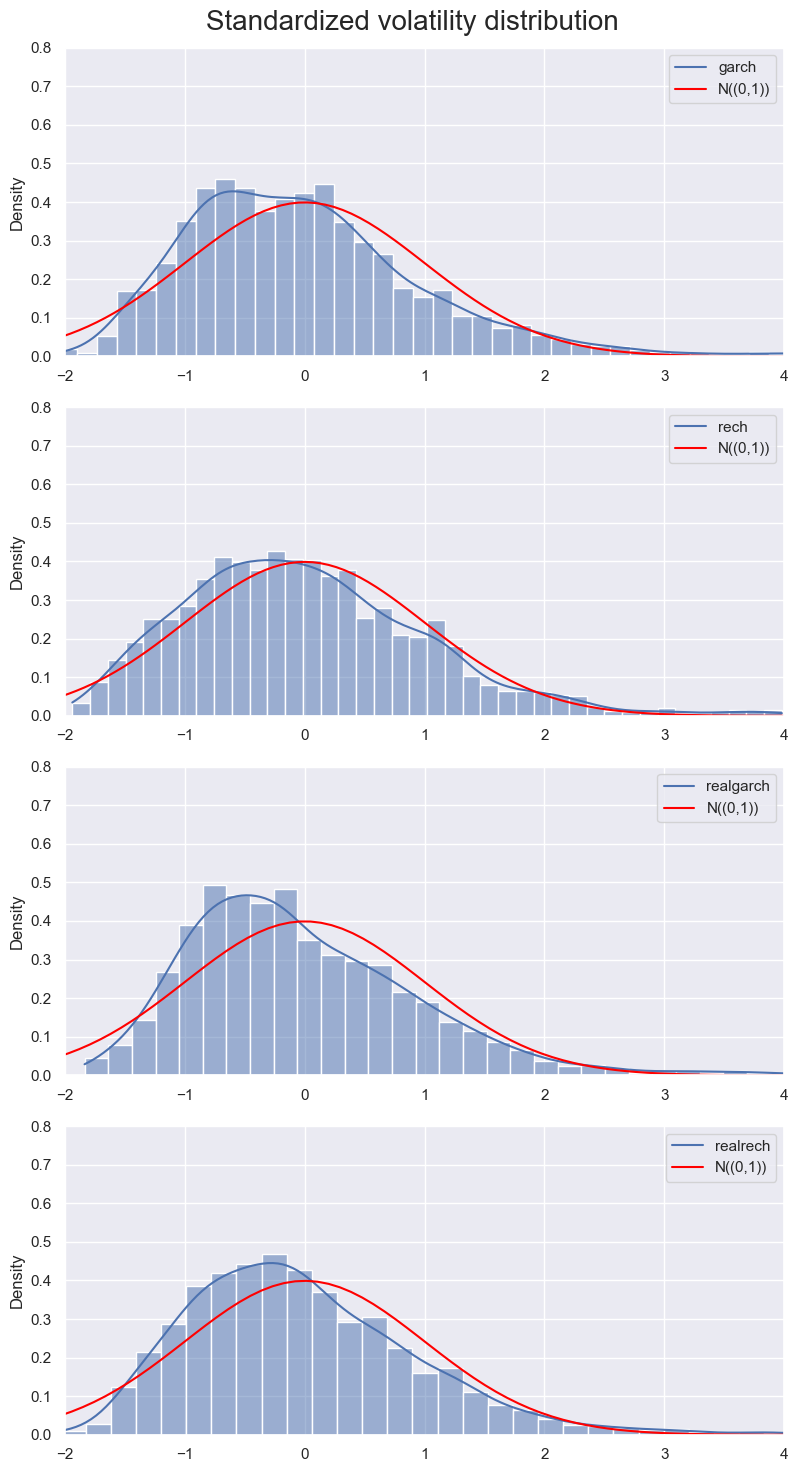

In [165]:
fig, axs = plt.subplots(4, figsize=(8,15))
fig.suptitle('Standardized volatility distribution', fontsize=20)
fig.tight_layout()
for mdk, ax in zip(mdk_ls, axs):
    ticker = 'GDAXI'
    y = data_dict[ticker]['test']['y_test']
    sigma = np.sqrt(md_dict[ticker][mdk].var_ls)
    sigma = np.log(sigma)
    sigma = (sigma-sigma.mean())/sigma.std()
    sns.histplot(sigma, stat='density', ax=ax, bins=bins, kde=True)
    mu, std = 0, 1
    xx = np.linspace(*ax.get_xlim(),100)
    ax.plot(xx, stats.norm.pdf(xx, mu, std), 'red', label='N(0,1)')
    ax.set_xlim(-2, 4)
    ax.set_ylim(0, 0.8)
    ax.legend(labels=[mdk, 'N((0,1))'])

## U distribution

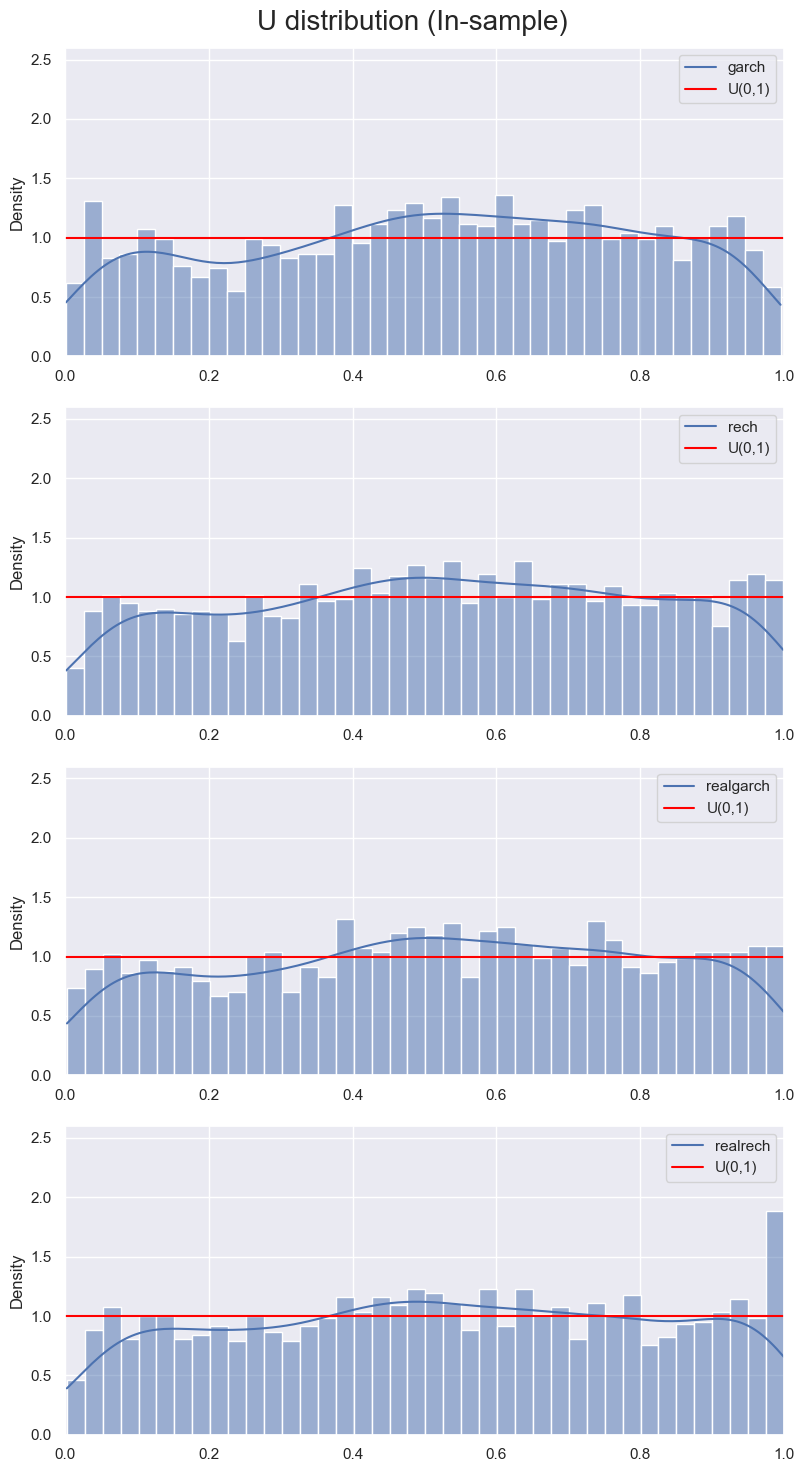

In [167]:
fig, axs = plt.subplots(4, figsize=(8,15))
fig.suptitle('U distribution (In-sample)', fontsize=20)
fig.tight_layout()
for mdk, ax in zip(mdk_ls, axs):
    ticker = 'GDAXI'
    y = data_dict[ticker]['test']['y_train']
    sigma = np.sqrt(md_dict[ticker][mdk].pre.var_ls)
    y = y[:sigma.shape[0]]
    res = y/sigma
    u = scipy.stats.norm.cdf(res)
    sns.histplot(u, stat='density', ax=ax, bins=bins, kde=True)
    mu, std = 0, 1
    xx = np.linspace(*ax.get_xlim(),100)
    ax.plot(xx, np.ones(shape=xx.shape), 'red')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 2.6)
    ax.legend(labels=[mdk, 'U(0,1)'])

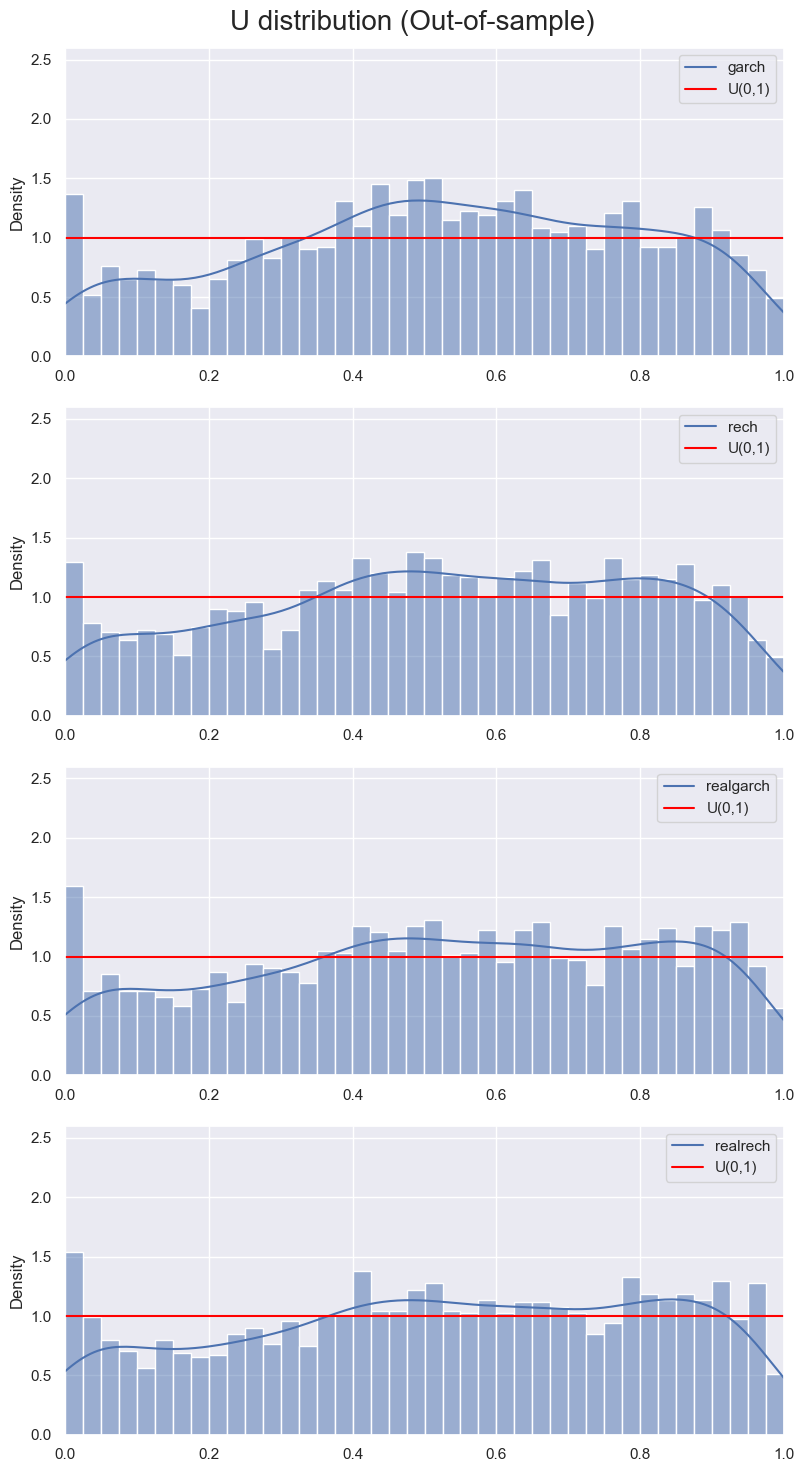

In [169]:
fig, axs = plt.subplots(4, figsize=(8,15))
fig.suptitle('U distribution (Out-of-sample)', fontsize=20)
fig.tight_layout()
for mdk, ax in zip(mdk_ls, axs):
    ticker = 'SPX'
    y = data_dict[ticker]['test']['y_test']
    res = y/np.sqrt(md_dict[ticker][mdk].var_ls)
    u = scipy.stats.norm.cdf(res)
    sns.histplot(u, stat='density', ax=ax, bins=bins, kde=True)
    mu, std = 0, 1
    xx = np.linspace(*ax.get_xlim(),100)
    ax.plot(xx, np.ones(shape=xx.shape), 'red')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 2.6)
    ax.legend(labels=[mdk, 'U(0,1)'])

## Residual distribution

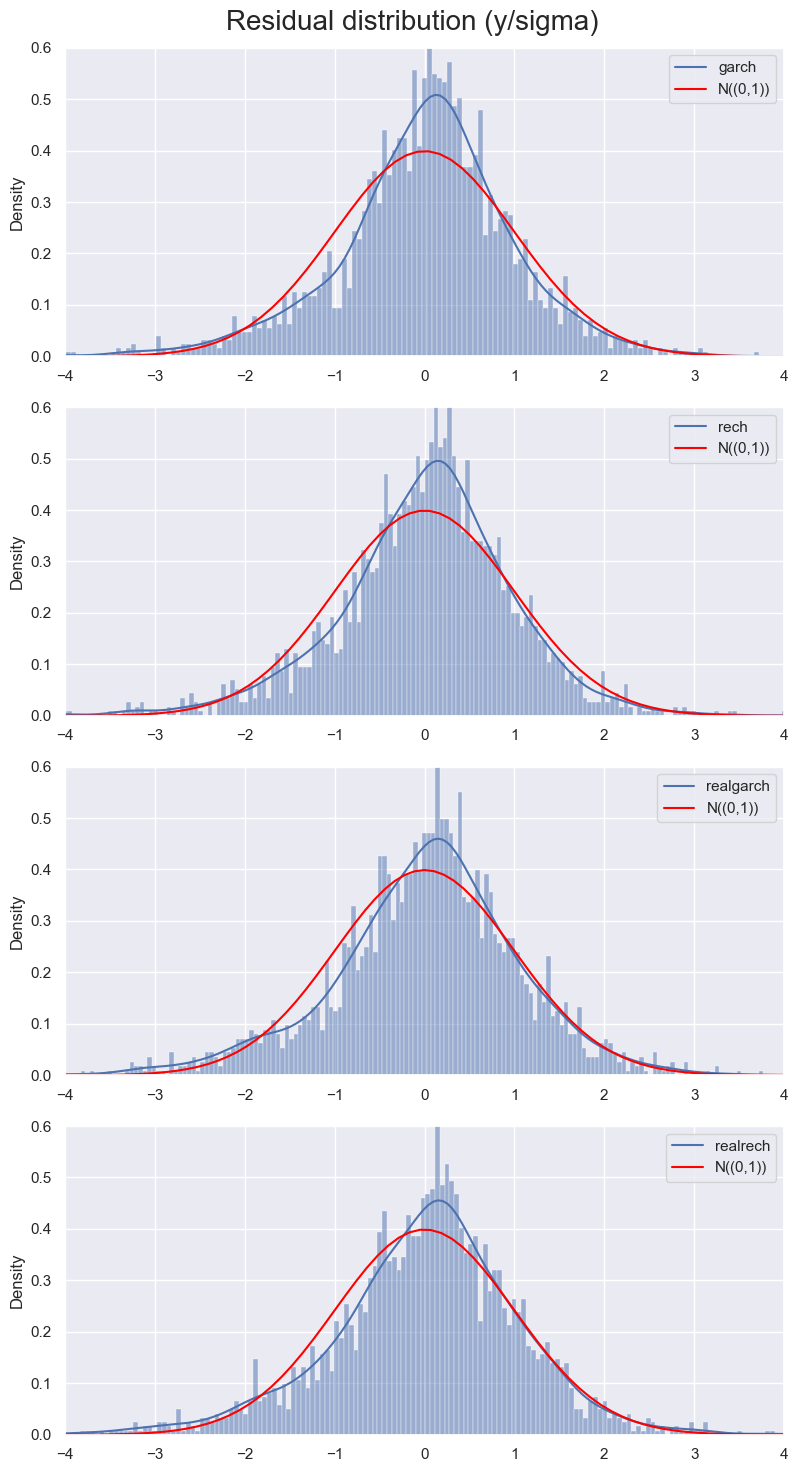

In [138]:
fig, axs = plt.subplots(4, figsize=(8,15))
fig.suptitle('Residual distribution (y/sigma)', fontsize=20)
fig.tight_layout()
for mdk, ax in zip(mdk_ls, axs):
    ticker = 'GDAXI'
    y = data_dict[ticker]['test']['y_test']
    res = pd.DataFrame(y/np.sqrt(md_dict[ticker][mdk].var_ls), columns=[mdk])
    sns.histplot(res, stat='density', ax=ax, bins=bins, kde=True)
    mu, std = 0, 1
    xx = np.linspace(*ax.get_xlim(),100)
    ax.plot(xx, stats.norm.pdf(xx, mu, std), 'red', label='N(0,1)')
    ax.set_xlim(-4, 4)
    ax.set_ylim(0, 0.6)
    ax.legend(labels=[mdk, 'N((0,1))'])